# Exercise 12: Convolutional Neural Networks
$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\zb}{\mathbf{z}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\Lb}{\mathbf{L}}$
$\DeclareMathOperator*{\argmin}{argmin}$

Welcome to the 12th practical session.

In this project, different neural network architectures are implemented with PyTorch, followed by practicing performing convolution on images. 

In [5]:
# 3rd party
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Project files.
from helpers import accuracy, visualize_convolution, load_blackwhite_image, DrawingPad

In [6]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device = torch.device(('cpu', 'cuda')[torch.cuda.is_available()])

## Part 1: PyTorch

### 1.1: About PyTorch

[PyTorch](https://pytorch.org/) is an optimized tensor library for deep learning using GPUs and CPUs. It allows
for fast prototyping by providing high level access to all necessary building blocks including NN layers, activation functions, loss functions or optimizers to name a few. Most importantly, however, PyTorch implements the [autograd](https://pytorch.org/docs/stable/autograd.html) package which allows for automatic differentiation of the operations we use to define NN architectures. Put in other words, one only has to implement the forward pass, namely to combine desired layers, while the **backpropagation is computed automatically**.

### 1.2: Basic pipeline

In order to define and train deep net models, one would usually implement the following steps:

    1. Load the dataset.
    2. Define and instantiate a deep net architecture.
    3. Choose or implement a loss function (such as the mean squared error).
    4. Choose and instantiate an optimizer (such as the SGD).
    5. For each batch in the dataset:
        5.1. Load a batch.
        5.2. Run forward pass through your model.
        5.3. Compute the loss.
        5.4. Run backward pass, i.e. compute gradients of the loss w.r.t. the trainable parameters (weights).
        5.5. Update the weights using the optimizer.
        5.6. Zero-out the accumulated gradients before the next iteration.
        
The code will follow this pipeline.

### 1.3: Essential bulding blocks

This section gives a high-level summary of the most important components representing the bare minimum which you will need to start playing with PyTorch and deep net models. You might want to skim through the official tutorials as well, namely [What is PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) and [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py). Here is the list of the components which will be explained in more detail along with the code blocks.

  - **nn.Module**: Base class for NN architectures.
  - **criterion**: A loss function.
  - **backward-pass**: Derivatives computed by the auto-diff system.
  - **optimizer**: Updates the trainable parameters (weights) during training.


### 1.4: Loading the data

We are at the step (1) of the training pipeline. PyTorch provides us with the `Dataset` and `DataLoader` classes which manage the loading, shuffling and transformations of the data. Within our training loop we will treat our dataset as an *iterator* which returns the batches of data and associated labels.

As was the case of previous week, we will work with [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset where each sample is stored as $28 \times 28$ pixels grayscale image. The data are loaded as `torch.Tensor` data type.

In [8]:
batch_size = 128

class Flatten:
    def __call__(self, x):
        return x.flatten()
flatten = Flatten()
nw_tr = 0
nw_te = 0
##############################################

# Dataset and DataLoader for MLP.
ds_fc_tr = MNIST('data', train=True, download=True, transform=Compose([ToTensor(), flatten]))
ds_fc_te = MNIST('data', train=False, download=True, transform=Compose([ToTensor(), flatten]))
dl_fc_tr = DataLoader(ds_fc_tr, batch_size=batch_size, shuffle=False, num_workers=nw_tr)
dl_fc_te = DataLoader(ds_fc_te, batch_size=batch_size, shuffle=False, num_workers=nw_te)

# Dataset for CNN.
ds_cnn_tr = MNIST('data', train=True, download=True, transform=ToTensor())
ds_cnn_te = MNIST('data', train=False, download=True, transform=ToTensor())
dl_cnn_tr = DataLoader(ds_cnn_tr, batch_size=batch_size, shuffle=False, num_workers=nw_tr)
dl_cnn_te = DataLoader(ds_cnn_te, batch_size=batch_size, shuffle=False, num_workers=nw_te)

ntr = len(ds_fc_tr)
nva = len(ds_fc_te)
print('Loaded {} tr and {} va samples.'.format(ntr, nva))

Loaded 60000 tr and 10000 va samples.


### 1.5: Multi-Layer Perceptron (MLP)

#### Architecture

We are at step (2) of the training pipeline. We will start with implementing a MLP consisting of a 1D input layer (we flatten the input image) of shape ($784$, ), $3$ hidden fully connected layers and an output layer of shape ($10$, ), as we have $10$ classes. 

#### Optimization criterion

We would like to interpret the output vector $\zb \in \real^{10}$ as the probabilities of data sample $\xb \in \real^{784}$ belonging to each class $j \in \{1, 2, ... 10\}$. Therefore, we will make use of the activation function **softmax** defined as:

$$ P(\text{class}=j|\zb) = \frac{\exp{\zb^{\top}\wb_{j}}}{\sum_{k=1}^{10}{\exp{\zb^{\top}\wb_{k}}}}. $$

Let $\zb'$ be the predicted probability distribution with $\zb'_{j} = \text{softmax}_{j}(\zb)$. Softmax guarantees that $\sum_{k=1}^{10}{\zb'_{k}} = 1$, meaning that out predicted vector $\zb'$ is indeed a valid probability distribution over classes. 

Finally, we would like to match the predicted distribution $\zb'$ to the ground truth (GT) one $\yb$, where $\yb$ is given by one-hot encoding ($\yb$ is all zeros except $1$ at the index $j$, if $j$ is correct class to be predicted). The optimization criterion of choice is then to minimize the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy) (CE) of $\zb'$ and $\yb$, therefore our final loss function $L$ is defined as:

$$ L = \text{CE}(\yb, \zb').$$

Thankfully, PyTorch has got us covered by providing the implementation of $L$, so you will only really need to provide the output $\zb$ (i.e. the 10-dimensional output of your last layer). We will get back to $L$ later.

---

#### nn.Module
Each custom NN architecture has to subclass the [`nn.Module`](https://pytorch.org/docs/stable/nn.html#module) which conveniently keeps track of all the trainable parameters. The programmer has to to implement the constructor (`__init__`) and override the `forward()` function:

- **\_\_init__()**

Defines the layers (e.g. fully connected layer, 2D convolutional layer, etc.) in the constructor and `nn.Module` will automatically keep track of all the weights these layers contain.

- **forward()**

This function really defines the architecture, as the layers will be sequentally called in the desired order. Each time `forward()` is called (every training iteration), the so called **computational graph** is built. It is a directed acyclic graph (DAG) of nodes corresponding to the operations you have called. Each node defines the derivative of its outputs w.r.t. its inputs. The computational graph is then traversed in the reversed fashion once you call `backward()` and the derivatives are computed.

All the trainable parameters which the model consists of can be accessed via call to `model.parameters()` implemented in `nn.Module`. This comes in handy once instantiating your optimizer as you have to pass all the parameters you want it to manage.

---

The task is to define the MLP as depicted on the figure below. Please refer to the documentation and focus on
the classes `nn.Linear` to define the layers and `F.relu` to call the activation funtion.

<img src="img/mlp.png" width=800></img>


In [9]:
class FC(nn.Module):
    """ Standard Multi layer perceptron for classification into 10 
    classes. Consists of 4 FC layers, ReLU activations are used 
    for the first 3.
    """
    def __init__(self):
        """ Constructor, layers definitions go here. Only specify
        those layers which have any trainable parameters (but for
        instance not the activation functions as the ones we use 
        do not have any trainable parameters). """
        super(FC, self).__init__()

        #Your code here
        self._fc1 = nn.Linear(784, 512)
        self._fc2 = nn.Linear(512, 256)
        self._fc3 = nn.Linear(256, 128)
        self._fc4 = nn.Linear(128,10)

    def forward(self, x):
        """ Feed-forward pass, this is where the actual computation happens
        and the computational graph is built (from scratch each time this 
        function is called). """
        
        #Your code here
        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.relu(x)
        x = self._fc3(x)
        x = F.relu(x)
        x = self._fc4(x)
        #x = F.relu(x)
        return F.softmax(x, dim=1)
    
# Instantiate the model.
model_fc = FC().to(device)
print(model_fc)

FC(
  (_fc1): Linear(in_features=784, out_features=512, bias=True)
  (_fc2): Linear(in_features=512, out_features=256, bias=True)
  (_fc3): Linear(in_features=256, out_features=128, bias=True)
  (_fc4): Linear(in_features=128, out_features=10, bias=True)
)


**Q:** How many learnable parameters (weights) does this model have?


### 1.6: Inspecting the model architecture

Let us check the model architecture and see how many trainable parameters we really use. For this purpose we will use `torchsummary` package.

Notice the number of trainable parameters.

In [10]:
summary(model_fc, input_size=(28 * 28, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.17
----------------------------------------------------------------


### 1.7: Loss function

We are at step (3) of our pipeline. As explained above, our loss function $L$ will be $\text{CE}(\yb, \zb')$, which is provided for us by PyTorch.

There are [many commonly used loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) defined in the `torch.nn` module and one can implement their own using PyTorch operations as well. 

In [14]:
# Define the loss fuction.
criterion = nn.CrossEntropyLoss()

### 1.8: Optimizer
We are at step (4) of the pipeline. [Optimizer](https://pytorch.org/docs/stable/optim.html) updates the weights given the currently computed gradients. It can be a simple state-less function (such as SGD) or one of more advanced ones which keep track of additional information about the weights and the gradients (such as a running mean) which can be used for smarter update rules.

We will opt for the simplest case, the state-less SGD. Your task is to instantiate this optimizer, please refer to [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [15]:
learning_rate = 0.2
opt = torch.optim.SGD(model_fc.parameters(), lr=learning_rate) #your code here

### 1.10: Training loop

We are at step (5) of our pipeline. We would like to define a training loop where we iterate over training samples and train our model. Let us define a function `train_model()` which will be used for training any architecture we come up with.

Fill in the code which follows the steps 5.2 - 5.6 of our training pipeline. For running the backward pass, use the function [`backward()`](https://pytorch.org/docs/stable/autograd.html?highlight=backward#torch.autograd.backward). For zeroing out the accumulated gradients, use the function [`zero_grad()`](https://pytorch.org/docs/stable/nn.html?highlight=zero_grad#torch.nn.Module.zero_grad).

In [16]:
def train_model(model, crit, opt, dl_tr, dl_te, epochs):
    for ep in range(epochs):
        # Training.
        model.train()
        for it, batch in enumerate(dl_tr):
            # 5.1 Load a batch.
            x, y = [d.to(device) for d in batch]

            # 5.2 Run forward pass.
            y_hat = model.forward(x) #your code here
            
            # 5.3 Compute loss (using 'criterion').
             #your code here
            loss = crit(y_hat, y)
            
            # 5.6 Zero-out the accumualted gradients.
            #your code here
            opt.zero_grad()
            
            # 5.4 Run backward pass.
            #your code here
            loss.backward()
            
            # 5.5 Update the weights using optimizer.
            #your code here
            opt.step()
            
            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(dl_tr), loss,
                         accuracy(y_hat, y)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dl_te):
                # Get batch of data.
                x, y = [d.to(device) for d in batch]
                curr_bs = x.shape[0]
                acc_run += accuracy(model(x), y) * curr_bs
            acc = acc_run / nva

            print(', accuracy test: {:.2f}'.format(acc))

### Training the model

In [17]:
epochs = 5
train_model(model_fc, criterion, opt, dl_fc_tr, dl_fc_te, epochs)

Ep 1/5, it 469/469: loss train: 2.09, accuracy train: 0.42, accuracy test: 0.48
Ep 2/5, it 469/469: loss train: 1.74, accuracy train: 0.72, accuracy test: 0.74
Ep 3/5, it 469/469: loss train: 1.72, accuracy train: 0.74, accuracy test: 0.75
Ep 4/5, it 469/469: loss train: 1.67, accuracy train: 0.82, accuracy test: 0.82
Ep 5/5, it 469/469: loss train: 1.63, accuracy train: 0.83, accuracy test: 0.84


## Part 2: Convolutional Neural Networks (CNNs)

Our 4 layered MLP network works well reaching test accuracy of ~0.85. However, this network uses ~0.5M weights. We can use even deeper architectures with less weights and take the advantage of the 2D structure of the input data (images) using CNNs.

### 2.1: LeNet-5

Let us define a simple CNN network of 2 convolutional layers with max-pooling and 3 FC layers. In particular, we will implement a variant of the architecture called [LeNet-5 introduced by Yann LeCun in 1999](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf). 


The simple LeNet-5 architecture depicted in the figure below is implemented. 
<img src="img/lenet5.png" width=800></img>



In [18]:
class CNN_LeNet(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self):
        super(CNN_LeNet, self).__init__()

        #your code here
        self._conv2d1 = nn.Conv2d(1, 6, 3, padding=(1,1))
        self._conv2d2 = nn.Conv2d(6, 16, 3, padding=(1,1))
        self._fc1 = nn.Linear(784, 120)
        self._fc2 = nn.Linear(120, 84)
        self._fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #your code here

        x = self._conv2d1(x)        
        x = F.max_pool2d(F.relu(x), 2)
        
        x = self._conv2d2(x)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.relu(x)
        x = self._fc3(x)
        return F.softmax(x, dim=1)
    
# Instantiate the model.
model_lenet = CNN_LeNet().to(device)
print(model_lenet)

CNN_LeNet(
  (_conv2d1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (_conv2d2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (_fc1): Linear(in_features=784, out_features=120, bias=True)
  (_fc2): Linear(in_features=120, out_features=84, bias=True)
  (_fc3): Linear(in_features=84, out_features=10, bias=True)
)


Let us check the architecture again and the number of trainable parameters. We can directly see that this architecture needs just about 20% of the parameters the MLP used.

In [19]:
# Print out the architecture and check the number of parameters.
summary(model_lenet, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
            Conv2d-2           [-1, 16, 14, 14]             880
            Linear-3                  [-1, 120]          94,200
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 106,154
Trainable params: 106,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.40
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


In [20]:
# Train the model

learning_rate = 0.1
epochs = 10
lenet_crit = nn.CrossEntropyLoss() 

opt_lenet = torch.optim.SGD(model_lenet.parameters(), lr=learning_rate)
train_model(model_lenet, lenet_crit, opt_lenet, dl_cnn_tr, dl_cnn_te, epochs)

Ep 1/10, it 469/469: loss train: 2.30, accuracy train: 0.30, accuracy test: 0.39
Ep 2/10, it 469/469: loss train: 1.63, accuracy train: 0.88, accuracy test: 0.79
Ep 3/10, it 469/469: loss train: 1.60, accuracy train: 0.86, accuracy test: 0.91
Ep 4/10, it 469/469: loss train: 1.52, accuracy train: 0.94, accuracy test: 0.85
Ep 5/10, it 469/469: loss train: 1.49, accuracy train: 0.97, accuracy test: 0.93
Ep 6/10, it 469/469: loss train: 1.51, accuracy train: 0.96, accuracy test: 0.93
Ep 7/10, it 469/469: loss train: 1.51, accuracy train: 0.95, accuracy test: 0.91
Ep 8/10, it 469/469: loss train: 1.49, accuracy train: 0.97, accuracy test: 0.96
Ep 9/10, it 469/469: loss train: 1.51, accuracy train: 0.96, accuracy test: 0.95
Ep 10/10, it 469/469: loss train: 1.48, accuracy train: 0.98, accuracy test: 0.97


### 2.2: 3-layered CNN

Let us now define even deeper CNN with 3 convolutional layers and only 2 FC layers. This network should reach higher accuracy (or converge faster) and still use less parameters than the previous architectures. The number of parameters displayed in `torchsummary` shows this.

The 3 layered CNN depicted in the figure below will be the next to implement.

<img src="img/cnn.png" width=800></img>

In [21]:
class CNN(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self, filters=(16, 32, 64)):
        super(CNN, self).__init__()

        self._conv2d1 = nn.Conv2d(1, filters[0], 3, 1, padding=1)
        self._conv2d2 = nn.Conv2d(filters[0], filters[1], 3, 1, padding=1)
        self._conv2d3 = nn.Conv2d(filters[1], filters[2], 3, 1, padding=1)
        self._fc1 = nn.Linear(3 * 3 * filters[2], 128)
        self._fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #your code here
        x = self._conv2d1(x)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = self._conv2d2(x)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = self._conv2d3(x)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = torch.flatten(x, start_dim=1)
    
        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        return F.softmax(x, dim=1)

# Instantiate the model.
filters = [5, 10, 25]
model_cnn = CNN(filters).to(device)

In [22]:
# Print out the architecture and number of parameters.
summary(model_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 28, 28]              50
            Conv2d-2           [-1, 10, 14, 14]             460
            Conv2d-3             [-1, 25, 7, 7]           2,275
            Linear-4                  [-1, 128]          28,928
            Linear-5                   [-1, 10]           1,290
Total params: 33,003
Trainable params: 33,003
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.13
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [18]:
# Train the model.
opt_cnn = torch.optim.SGD(model_cnn.parameters(), lr=0.5)
train_model(model_cnn, lenet_crit, opt_cnn, dl_cnn_tr, dl_cnn_te, epochs)

Ep 1/10, it 469/469: loss train: 2.30, accuracy train: 0.09, accuracy test: 0.11
Ep 2/10, it 469/469: loss train: 1.72, accuracy train: 0.74, accuracy test: 0.72
Ep 3/10, it 469/469: loss train: 1.64, accuracy train: 0.81, accuracy test: 0.85
Ep 4/10, it 469/469: loss train: 1.58, accuracy train: 0.88, accuracy test: 0.87
Ep 5/10, it 469/469: loss train: 1.49, accuracy train: 0.97, accuracy test: 0.96
Ep 6/10, it 469/469: loss train: 1.47, accuracy train: 0.99, accuracy test: 0.97
Ep 7/10, it 469/469: loss train: 1.48, accuracy train: 0.98, accuracy test: 0.97
Ep 8/10, it 469/469: loss train: 1.53, accuracy train: 0.93, accuracy test: 0.96
Ep 9/10, it 469/469: loss train: 1.47, accuracy train: 0.99, accuracy test: 0.97
Ep 10/10, it 469/469: loss train: 1.47, accuracy train: 0.99, accuracy test: 0.97


### 2.3: Trying out your own input

We have provided a tool for you to draw your own digits and test your network. Play around with the inputs to get a sense of how accurate your model is. Us the button `reset` to reset the canvas and `predict` to run the prediction on current canvas image. You can use the button `blur` to blur your drawn image so that it looks closer to the samples from the training set.

<IPython.core.display.Javascript object>


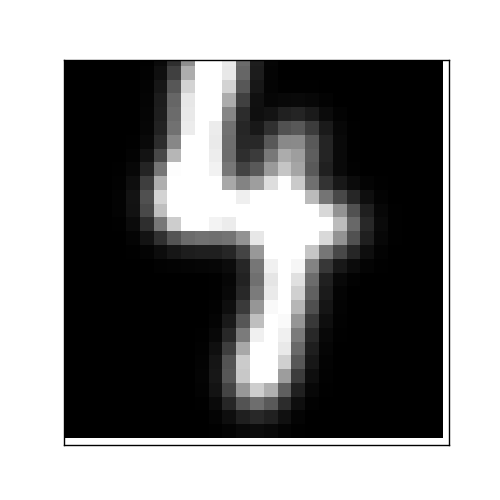

Button(description='reset', style=ButtonStyle())

Button(description='blur', style=ButtonStyle())

Button(description='predict', style=ButtonStyle())

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

In [23]:
dp = DrawingPad((28, 28), (10, 10), device="cpu")

In [25]:
pred = model_cnn(torch.from_numpy(dp.grid).to(device)[None, None])
clp = torch.argmax(pred)
print("Your prediction:", clp.item())

Your prediction: 4


## Part 3: Convolution

In this part, we will go into more detail about the convolution operation, which is used extensively in CNNs. 

### 3.1: Introduction: 1-D Convolution

Let's recall the definition of the convolution operation.

$$ y[i] = \sum_{m=- \infty}^{\infty} x[m] \cdot h[i-m] $$

We notice that the steps for convolution in this case are the following:
* We flip our filter $h[m]$ so that it becomes $h[-m]$.
* We shift $h[-m]$ to index $i$ so that it becomes $h[i-m]$.
* Multiply the two arrays $x[m]$ and $h[i-m]$ and sum over all values of $m$.
* As we calculate this for each index $i$, we are sliding filter $h[m]$ over $x[m]$ and repeating the steps above.

Consider the input array $x$ and filter $h$ given below:
$$x = [2,2,2,2,2,2,2,10,10,10,10,10,1,1,1,1,1,1,1,1,5,5,5,5,5] \\
h = [1, 0, -1]$$

Note that the filter is centered at index 0 ($h[-1]=1, h[0]=0, h[1]=1$)

Let's plot them to see what they look like:

In [26]:
x = np.array([2,2,2,2,2,2,2,10,10,10,10,10,1,1,1,1,1,1,1,1,5,5,5,5,5])
h = np.array([-1,0,1])

<IPython.core.display.Javascript object>


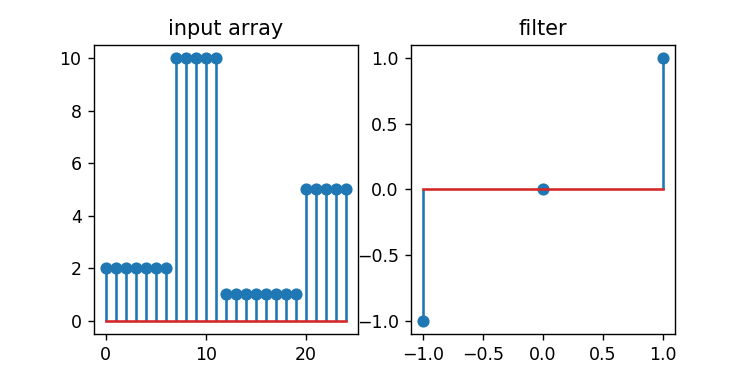

Text(0.5, 1.0, 'filter')

In [27]:
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.stem(x, use_line_collection=True)
plt.title("input array")

plt.subplot(1,2,2)
plt.stem(range(-1,2), h, use_line_collection=True)
plt.title("filter")

Below we have a visual explanation of convolution. 
Typing `q` into the input bar will quit the visualization.

<IPython.core.display.Javascript object>


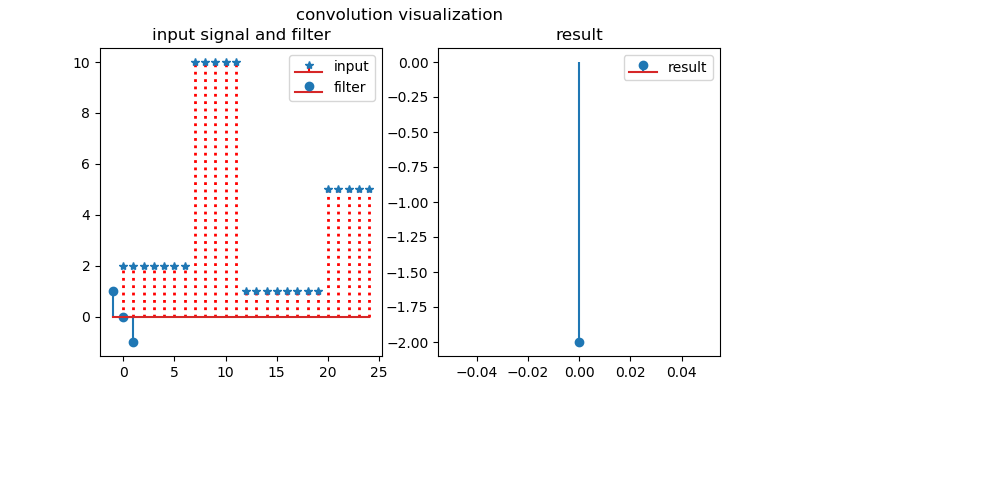

In [ ]:
visualize_convolution()


Notice that to calculate $y[0]$ you need the element $x[-1]$. A way to overcome this problem is to pad the input array with 0's. We pad both the beginning and the end of the array by `M//2` where $M$ denotes the filter size. The function to do padding for 1D arrays is given below.

In [ ]:
#function to add zero padding to input array
def add_padding_1d(x, filter_size):
    """
    Adds zero padding to a 1-d array.
    Args:
        x (np.array): Input array.
        filter_size (int): size of the filter used in convolution
    Returns:
        np.array: resulting zero padded array.
    """
    
    return np.concatenate([np.zeros([filter_size//2,]), x, np.zeros([filter_size//2,])])

In [ ]:
#function to compute 1-D convolution
def convolution_one_dimensional(x, h):
    """
    1-d convolution
    Args:
        x (np.array): Input array.
        h (np.array): Filter
    Returns:
        np.array: convolution result
    """
    
    filter_size = h.shape[0]
    input_array_size = x.shape[0]
    
    #adding padding to input array
    x = add_padding_1d(x, filter_size)
    
    padded_array_size = x.shape[0]
    
    #slide kernel over input array 
    y = np.zeros(input_array_size)
    
    for i in range(input_array_size):
        for j in range(filter_size):
            y[i] -= h[j]*x[i+j]
    
    
    return y

Run the code below to plot your result. We compare with numpy's `np.convolve()` function as a sanity check.

In [ ]:
y = convolution_one_dimensional(x, h)
sanity_check = np.convolve(a=x,v=h,mode='same')
print("My result", y)
print("Numpy's result", sanity_check)

plt.figure()
plt.subplot(1,1,1)
markerline, stemlines, baseline = plt.stem(x, linefmt=':', markerfmt="*", label="input", use_line_collection=True)
plt.setp(stemlines, color='r', linewidth=2)
plt.stem(y, label="result", use_line_collection=True)
plt.title("result")
plt.legend()

This filter is doing edge detection. It gives a response whenever the values in the array change. The more sudden the change, the greater magnitude of the response. 

### 3.2: 2-D Convolution and Trying Different Image Filters

In a similar way, 2D convolution is defined as the following:

$$ y[i, j] = \sum_{m} \sum_{n} x[m, n] \cdot h[i-m, j-n] $$

In this case, we have 2D filters that we slide over our image. 

It's important to observe the effects of convolving images with different filters to get an idea of what our Convolutional Neural Networks learn to "see" in the images.

Let's load an image to test some filters on.

In [ ]:
#true_logo = load_blackwhite_image(image_name="img/old_logo.png")
true_logo = load_blackwhite_image(image_name="img/new_logo.png")

plt.figure()
plt.imshow(true_logo, cmap='gray')

We will create some Gaussian filters and observe their effect on our images. 


In [ ]:
def gaussian_filter(sigma, filter_size):
    x = np.linspace(-1,1,filter_size)
    filter_one_d = np.exp(-0.5*(x/sigma)**2)
    filter_res = np.dot(filter_one_d[:,None], filter_one_d[:,None].T)
    filter_res = filter_res/np.sum(filter_res)
    return filter_res

#try different filters given below:
filter_1 = gaussian_filter(sigma=0.2, filter_size=8)
filter_2 = gaussian_filter(sigma=0.5, filter_size=8)
filter_3 = gaussian_filter(sigma=5, filter_size=8)

gaussian_filters = [filter_1, filter_2, filter_3]

In [ ]:
for ind, a_filter in enumerate(gaussian_filters):
    result = convolve2d(true_logo, a_filter, mode="same")

    #visualize filter and resulting image
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(a_filter, cmap='gray')
    plt.title("filter "+ str(ind))
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(result, cmap='gray')
    plt.colorbar()

Now let us create a horizontal and a vertical Sobel operator and convolve it with the image.

In [ ]:
filter_4 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
filter_5 = filter_4.T

sobel_filters = [filter_4, filter_5]

for ind, a_filter in enumerate(sobel_filters):
    result = convolve2d(true_logo, a_filter, mode="same")
    
    plt.figure(figsize=(9, 3))
    
    thresholded_result = np.zeros(result.shape)
    thresholded_result[result > np.mean(result)] = 1
    thresholded_result[result <= np.mean(result)] = 0

    #visualize filter and resulting image
    plt.subplot(1,3,1)
    plt.imshow(a_filter, cmap='gray')
    plt.title("filter "+ str(ind))
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,2)
    plt.imshow(result, cmap='gray')
    plt.title('result')
    plt.colorbar(fraction=0.04)
    
    plt.subplot(1,3,3)
    plt.imshow(thresholded_result, cmap='gray')
    plt.colorbar(fraction=0.046)
    plt.title('thresholded result')

We hand designed the filters ourselves, but in the case of CNNs, they learn what the filters look like. Oftentimes, the filters learned by CNNs in the early layers look like the filters we have just designed.
